In [1]:
import numpy as np
import pylab as plt

import numpy.fft as fft
import scipy.linalg
from scipy.linalg import solve
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import LinearOperator

from scipy.sparse.linalg import cg, gmres, cgs, lgmres, minres, qmr, gcrotmk, bicg, spsolve, bicgstab
from scipy.sparse import csc_matrix

import time
from IPython.display import Image

from tqdm.notebook import tqdm
from tqdm import tqdm

C:\Users\Geoff\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Geoff\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Geoff\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Geoff\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
from Define_Linear_Equation import Us, construct_A, construct_b, construct_Uf, Uf

In [3]:
from gibbs_utils import signal_covariance_sampler as SCS
from gibbs_utils import foreground_covariance_sampler as FCS
from gibbs_utils import binner, k_vecs

In [4]:
import os, psutil
import gc

In [5]:
# Plot some slices of a given datacube
def cube_plot(data_cube,vmin,vmax):
    fig, ax = plt.subplots(4, 4, figsize=(25, 25))

    g = 0
    for i in range(2):
        for j in range(4):
            #ax[i][j].imshow(np.abs(data_cube[g])**2)
            aa = ax[i][j].matshow(data_cube[g], cmap='magma', aspect='auto',vmin=vmin,vmax=vmax)
            ax[i][j].set_aspect('equal', adjustable='box')
            fig.colorbar(aa,ax=ax[i,j])
            g+=1
    
    fig.set_facecolor('white')
    plt.tight_layout()

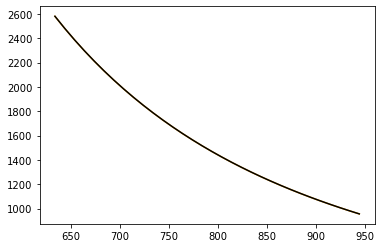

In [6]:
fg_cube = np.load('data/fg_cube_32.npy')
signal_cube = np.load('data/signal_cube_32.npy')
noise_cube = np.load('data/noise_cube_32.npy') #*0.01
freqs = np.load('data/freqs_32.npy')
shape = np.shape(signal_cube)

sigma_rms = np.load('data/sigma_rms_32.npy') # Sigma rms from fastbox

'''----------------------'''
n_modes = 5 # Number of FG modes for both the fiducial and model foregroudns
Uf_op = construct_Uf(n_modes,shape,freqs) # Define the operator U_f
'''----------------------'''

f_own = Uf(Uf_op, fg_cube, True) # Define the fiducial foregrounds with the fg cube. Apply the operator transpose to the true fg cube to get these modes

#f_own = f_own*np.random.normal(loc=1.0,scale=1e-5,size=np.shape(f_own))


f_own = f_own.reshape((shape[0],shape[0],n_modes)) 
fg_known = Uf(Uf_op, f_own, False).reshape(shape) # The fiducial foreground cube. Make it again in case of rounding errors etc.

fg_cube = fg_known

plt.plot(freqs,fg_cube[1][3],color='orange',label='True FG')
plt.plot(freqs,fg_cube[4][2],color='k',label='True FG')



In [7]:
data_cube = signal_cube + noise_cube + fg_cube  

In [8]:
sigma_rms

array([0.0212599 , 0.02135143, 0.02144646, 0.02154517, 0.02164773,
       0.02175435, 0.02186523, 0.02198059, 0.02210068, 0.02222573,
       0.02235603, 0.02249184, 0.02263349, 0.02278129, 0.0229356 ,
       0.02309677, 0.02326523, 0.02344138, 0.0236257 , 0.02381867,
       0.02402082, 0.02423272, 0.02445499, 0.02468829, 0.02493332,
       0.02519087, 0.02546176, 0.02574689, 0.02604725, 0.02636389,
       0.02669798, 0.02705075])

In [9]:
N = np.broadcast_to(sigma_rms, (shape)).flatten() # Create the noise cube, assuming the sigma rms is only dependent on frequency

# The weighting - number of pixels either side to downweight, and its factor
w = np.ones(shape)
w_pix = 5
w_factor = 1 # 1 = no weighting

w[:,0:w_pix] = w_factor # Frequency
w[:,-w_pix:] = w_factor # Frequency
w[:,:,0:w_pix] = w_factor
w[:,:,-w_pix:] = w_factor

Nw = (w.transpose().flatten())*(N*w.flatten())

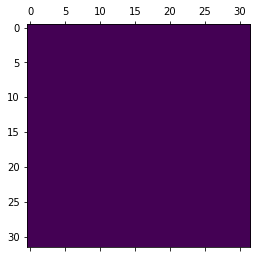

In [10]:
plt.matshow(w[0])

In [11]:
w = w.flatten()

In [12]:
# Define the shapes of the rfft results. For reshaping of flattened matrices
rfft_len = int((shape[0]**2)*(1 + shape[0]/2))
rfft_shape = (shape[0],shape[1],int(1+shape[2]/2))

In [13]:
def A_flat(x):
    """
    Takes the flattened x vector and reconstruct s and f to the appropriate shapes. 
    Forms Ax, to be compared with b
    """

    x0_recon = x[0:rfft_len].reshape(rfft_shape)

    x1_recon = x[rfft_len:].reshape(np.shape(f_own))
        
    Ax = construct_A(x0_recon, x1_recon, S, Nw, F, w, Uf_op)
    
    return Ax.flatten()

In [14]:
def res_binner_check(s_flat, nbins, cube_len):

    k = k_vecs(cube_len) # Get the k vectors

    k_min, k_max = min(k.flatten()), max(k.flatten()) # Bin range
    
    kbins = np.linspace(k_min, k_max, nbins+1) # bins

    binned_PS_out = [] # Group all the s which fall in the same bin
    binned_PS_sum_out = [] # Same as above, but sums all the s in a bin
    k_bins_out = [] # output the k bins corresponding to each individual s

    k_flat = k.flatten()

    s_bin_sums = np.zeros(cube_len**3) # Output the nxnxn S, with the value of the binned S in the correct voxel

    idxs_track = [] # Track the indices. Used to order the output S (?)
    #print(kbins)
    for i in range(0,len(kbins)-1):
        #print (i)
        idxs = np.where(np.logical_and(k_flat >= kbins[i], k_flat < kbins[i+1]))
        
        binned_PS_out.append( s_flat[idxs] )
        
        if len(s_flat[idxs]) < 3:
            print('< 3 modes in a bin')
            
        binned_PS_sum_out.append( np.sum(np.conj(s_flat[idxs]) * s_flat[idxs]) )

        #s_bin_sums[idxs] = np.sum(np.conj(s_flat[idxs]) * s_flat[idxs])
        
        k_bins_out.append( np.zeros(len(s_flat[idxs])) + kbins[i] )

        #idxs_track.append(idxs)
        
    return binned_PS_out, binned_PS_sum_out, kbins


In [15]:
"""
Turn sampling on/off and set the number of samples to be taken
All false and N_samples = 1 for MAP solution
"""

s_samp = False
f_samp = False
d_samp = False
S_samp = False
F_samp = False

N_samples = 1

In [16]:
"""Setup. Most of these should be reinitialised with each new run"""

# Set the initial fg amplitude guess - offset randomly from the true values by up to 10%
f_offset = np.broadcast_to(np.random.normal(loc=1.0,scale=0.1,size=n_modes), np.shape(f_own))
f_own_offset = f_own*f_offset

# The initial x vector - zeros for signal, offset for fg amplitudes
x0 = np.concatenate([np.zeros(rfft_len),f_own_offset.flatten()])

# The number of power spectrum bins
n_k_bins = 8

# Get an initial signal covariance, using the power spectrum estimate
binned_PS_out, binned_PS_sum_out, kbins = res_binner_check(signal_cube.flatten(), 8, shape[0])
S = np.array(np.concatenate(binned_PS_out))
S = np.concatenate([S, [S[-1]]])

# Initial foreground covariance (the variance of each amplitude across the cube)
F = np.array( [np.var((f_own_offset[:,:,0])), np.var((f_own_offset[:,:,1])), np.var((f_own_offset[:,:,2])), np.var((f_own_offset[:,:,3])), np.var((f_own_offset[:,:,4]))] )

# The linear operator to be evaluated
L = LinearOperator(matvec=A_flat,rmatvec=A_flat,shape=(len(x0),len(x0)))

# Track the traces of the covariances and power spectrum
F_trace = []
S_trace = []    
Pk_trace = []

"""Sample/solver"""

start = time.time()

for rr in tqdm(range(N_samples)):

    # The prior means
    s_mean = np.zeros(rfft_shape)
    f_mean = f_own_offset

    if s_samp:
        ws = np.random.normal(loc=0.0,scale=1,size=rfft_shape).flatten()
    else:
        ws = 0

    if f_samp:
        wf = np.random.normal(loc=0.0,scale=1,size=n_modes)
    else:
        wf = 0

    if d_samp:
        wd = np.random.normal(loc=0.0,scale=1,size=shape).flatten()
        b = construct_b(S, N, F, w, s_mean, f_mean, Uf_op, data_cube, ws, wf, wd)
    else:
        wd = 0
        b = construct_b(S, N, F, w, s_mean, f_mean, Uf_op, data_cube, ws, wf, wd)

    start2 = time.time()

    tol = 1e-8

    x, exit_code = lgmres(L, b.flatten(),x0=x0,tol=tol,atol=tol)
    #x, exit_code = minres(L, b.flatten(),x0=x0,tol=tol)

    #x, exit_code = cg(L, b.flatten(),x0=x0,tol=tol,atol=tol)
    #x, exit_code = cgs(L, b.flatten() ,x0=x0,tol=tol,atol=tol)
    #x, exit_code = bicg(L, b.flatten(),x0=x0,tol=tol,atol=tol)
    #x, exit_code = bicgstab(L, b.flatten(),x0=x0,tol=tol,atol=tol)
    #x, exit_code = qmr(L, b.flatten(),x0=x0,tol=tol,atol=tol)
    #x, exit_code = gcrotmk(L, b.flatten(),x0=x0,tol=tol,atol=tol)

    if S_samp:
        S_trace.append(S)
        
        s = x[0:rfft_len].reshape(rfft_shape)

        # Inverse and forward FT to get the shape right for the S binning and sampling
        s = np.fft.irfftn(s)
        s = np.fft.fftn(s)
        #s = s - np.mean(s)

        # Use the binner in gibbs_utils.py, which just bins Fourier modes (no summation)
        binned_s_out, k_bins_out, idxs_track = binner(s.flatten(), n_k_bins, len(s))

        # Pass the binned modes (s_k) to the S covariance sampler
        S, PkSample = SCS(np.concatenate(binned_s_out),np.concatenate(k_bins_out))
        S = np.concatenate([S, [S[-1]]]) # Fix: One less element than needed (?)

        S_trace.append(S)
        Pk_trace.append(PkSample)
    else:
        pass

    if F_samp:
        F_trace.append(F)

        x_1_recon_soln = x[rfft_len:].reshape(np.shape(f_own))

        # Use only the real parts for the Ffg covariance sampling
        F = FCS(x_1_recon_soln.reshape((shape[0]**2,n_modes)).real)
        if n_modes > 1:
            F = np.diag(F)
    else:
        pass


    end2 = time.time()

    x0 = x # Update solver starting point with new sample

    # Save the sample
    np.save(arr=x,file='solns/x_sample_' + str(rr) + '.npy')
    
    
    gc.collect()

# Save the PS and F trace
np.save(file = 'Pk_trace.npy', arr = Pk_trace)
np.save(file = 'F_trace.npy', arr = F_trace)
#np.save(file = 'S_trace.npy', arr = S_trace)

end = time.time()
print((end - start))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.09it/s]

0.9307925701141357


In [17]:
check = rr  # Check the last sample with some plots
x_solns = np.load('solns/x_sample_' + str(check) + '.npy')

x_0_recon_soln = x_solns[0:rfft_len].reshape(rfft_shape)

x_1_recon_soln = x_solns[rfft_len:].reshape(np.shape(f_own)).real

### True Signal

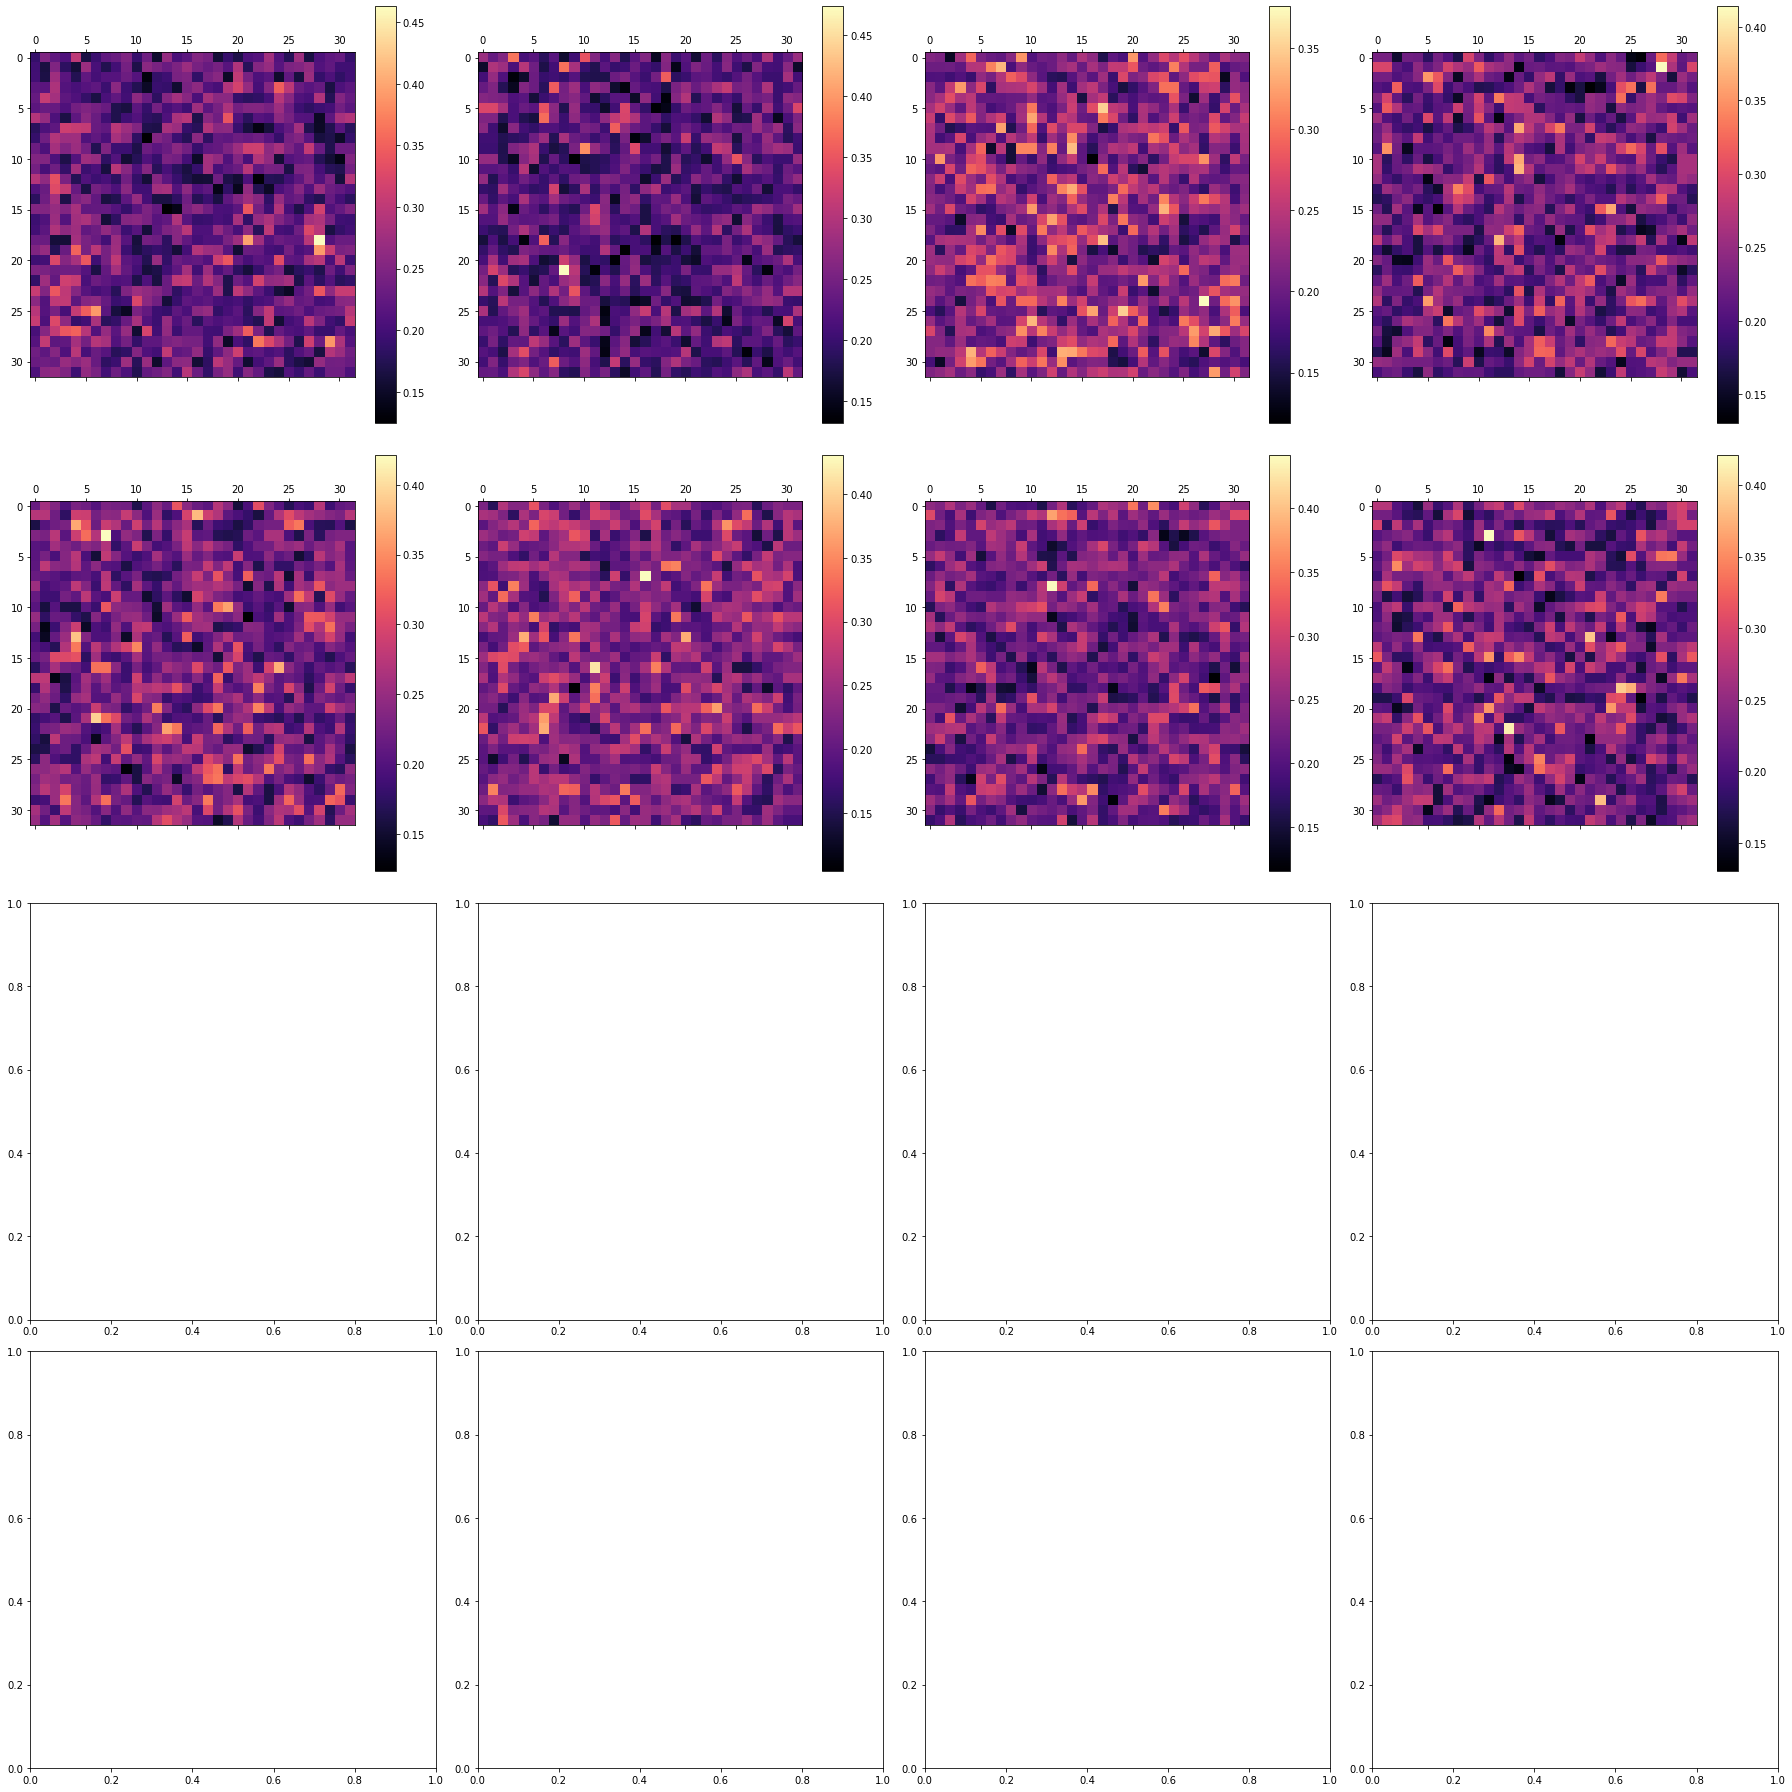

In [19]:
cube_plot(signal_cube,None,None)

### Model

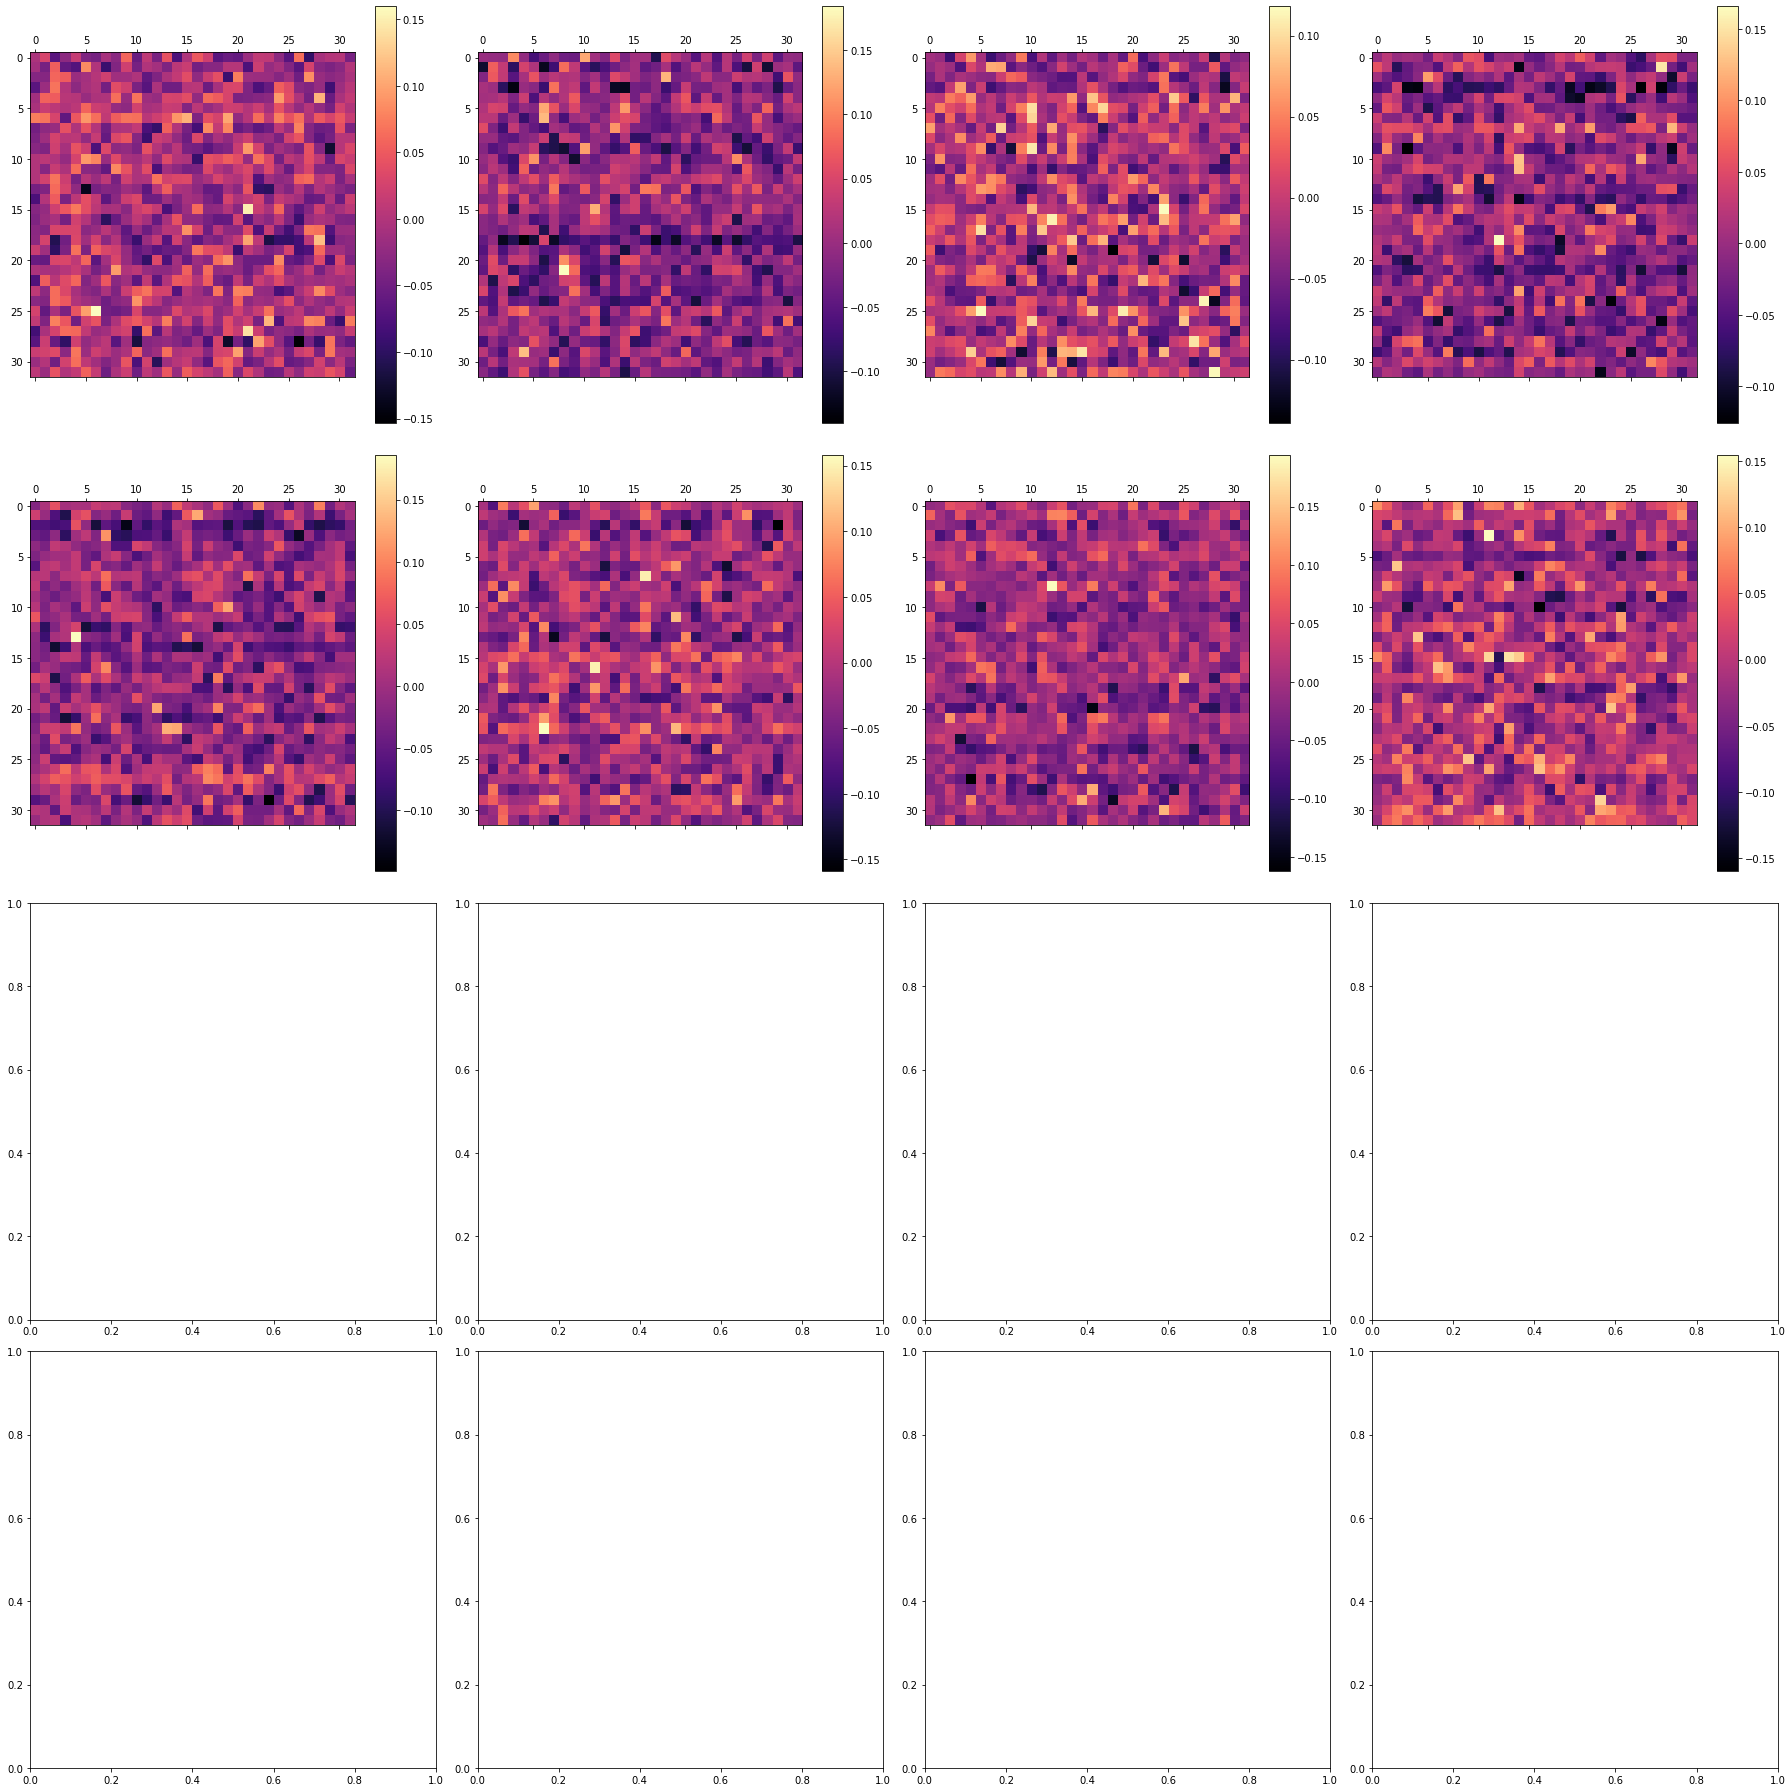

In [18]:
cube_plot( Us(x_0_recon_soln,False),None,None)

In [19]:
# Choose a random frequency slice from the true and the last model sample foreground cubes to check
a_i, b_i = np.random.randint(0,shape[0]), np.random.randint(0,shape[0])

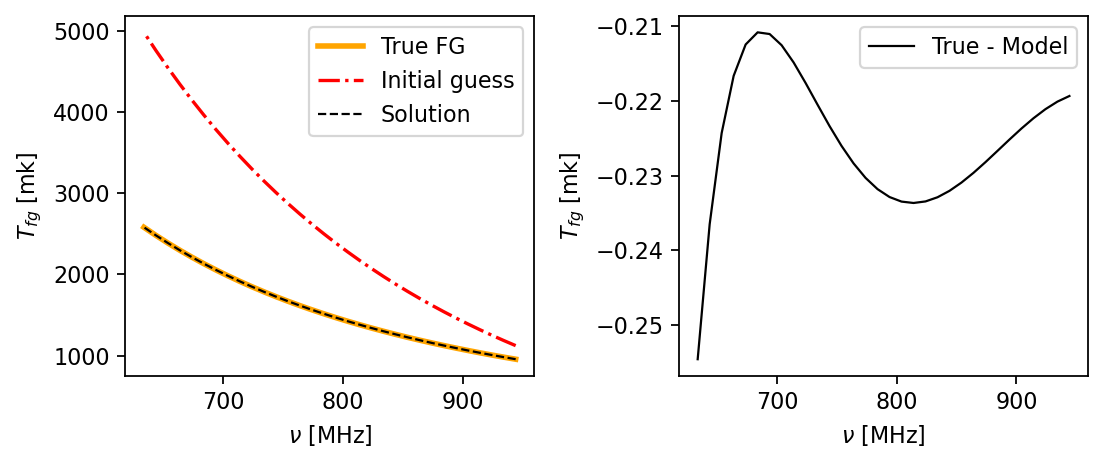

In [20]:
cmap = 'plasma'

fig, ax = plt.subplots(1,2,figsize=(7, 3), dpi=160)


ax[0].plot(freqs,fg_cube[a_i][b_i],color='orange',label='True FG',linewidth=2.5)
ax[0].plot(freqs,Uf(Uf_op,f_own_offset,transpose=False).reshape(shape)[a_i][b_i],linestyle='-.',color='red',label='Initial guess')
ax[0].plot(freqs,Uf(Uf_op,x_1_recon_soln,transpose=False).reshape(shape)[a_i][b_i],linestyle='--',color='k',label='Solution',linewidth=1)
ax[0].set_xlabel('$\\nu$ [MHz]')
ax[0].set_ylabel('$T_{fg}$ [mk]')
ax[0].legend()

ax[1].plot(freqs,fg_cube[a_i][b_i] - Uf(Uf_op,x_1_recon_soln,transpose=False).reshape(shape)[a_i][b_i],color='k',label='True - Model',linewidth=1)
ax[1].set_xlabel('$\\nu$ [MHz]')
ax[1].set_ylabel('$T_{fg}$ [mk]')
ax[1].legend()

plt.tight_layout()

#plt.title('$\mathbf{F}_{ij}$ = np.var(f)$\\times10^{-10}$ $\sim 5e2$')
#plt.title('$\mathbf{F}_{ij}$ = np.var($f_{i})\\times10^{-3}$')
#plt.savefig('plots/f_comp_0_pix.jpg',bbox_inches='tight')

### PS estimate

Plot the PS estimate (?): $\sigma_k^2 = \Sigma s*_{k,q+1} s_{k,q+1}$ (Eq. 18 in paper)

For a MAP solution this works, for sampling it doesn't. For the latter one should plot the mean (see below)

In [21]:
# Set the number of bins for the PS
n_k_bins = 8

In [22]:
# The mean subtracted model signal result (with the correct shape)
s_res = np.fft.fftn(np.fft.irfftn(x_0_recon_soln) - np.mean(np.fft.irfftn(x_0_recon_soln)))

binned_PS_out, binned_PS_sum_out, k_bins_out = res_binner_check(s_res.flatten(), n_k_bins, len(s_res))

In [23]:
# The mean subtracted true signal (with the correct shape)
s_true = np.fft.fftn(signal_cube - np.mean(signal_cube))

binned_PS_out_true, binned_PS_sum_out_true, k_bins_out_true = res_binner_check(s_true.flatten(), n_k_bins, len(s_true))

C:\Users\Geoff\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Geoff\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'log($\\sigma_k^2$)')

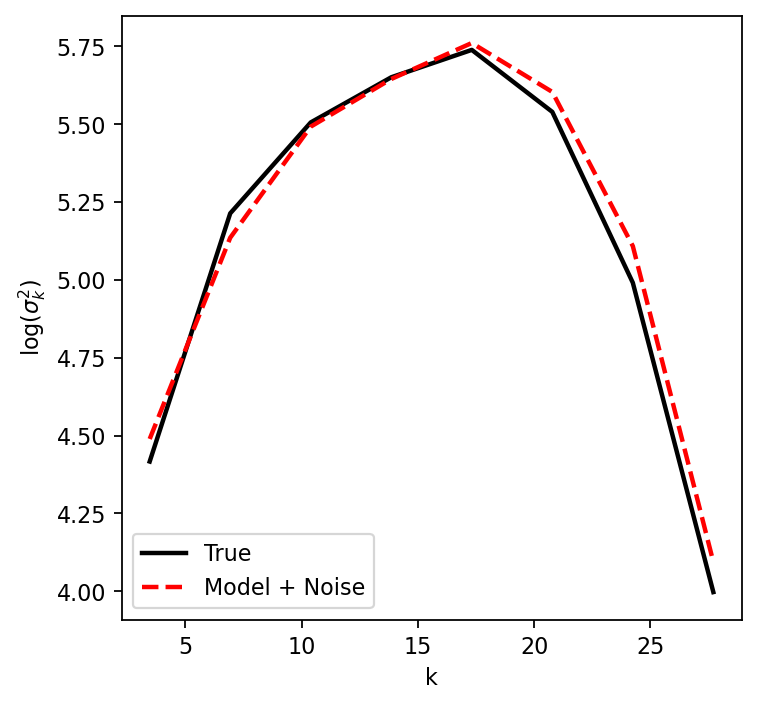

In [24]:
fig, ax = plt.subplots(figsize=(5, 5),dpi=160)


plt.plot(k_bins_out[1:], np.log10(binned_PS_sum_out_true),linewidth=2, label='True', color='k')
plt.plot(k_bins_out[1:], np.log10(binned_PS_sum_out),linestyle='--',linewidth=2,label='Model + Noise',color='r')

plt.legend()
plt.xlabel('k')
plt.ylabel('log($\sigma_k^2$)')
#plt.savefig('plots/sig2_comp_128.jpg',bbox_inches='tight')

### Traces

In [39]:
xses = []
s_trace = []
ffts_trace = []
f_trace = []
PS_trace = []

xs_ft_trace = []

cut = 0
m = N_samples

for jj in tqdm(range(cut,m)): 
    samp = np.load('solns/x_sample_' + str(jj) + '.npy')
    xs = samp[0:rfft_len].reshape(rfft_shape)

    xs_ft_trace.append(Us(xs,False).real)
    
    xf = samp[rfft_len:].reshape(np.shape(f_own))
    
    s_trace.append(xs.flatten())
    f_trace.append(xf)

    
    xses.append(xs)

# The mean of the signal Fourier modes
x_m = np.mean(xses, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 92.14it/s]


Text(0.5, 0, 'step')

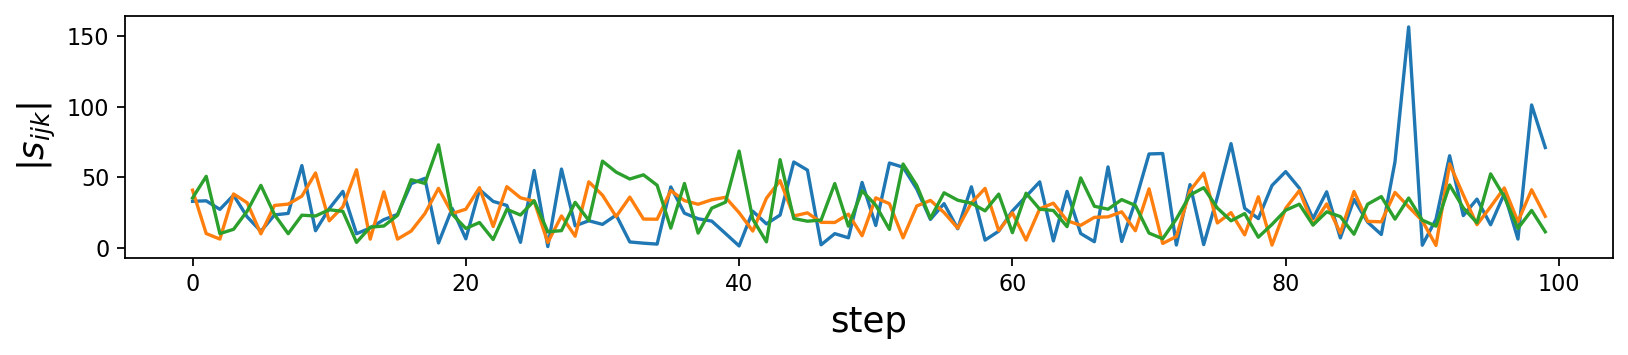

In [40]:
"""The absolute values of some Fourier modes"""

fig, ax = plt.subplots(figsize=(12, 2),dpi=160)

i, j, k = 3,2,0
plt.plot(np.arange(cut,m,1),np.abs(np.array(xses)[:,i,j,k]))
plt.plot(np.arange(cut,m,1),np.abs(np.array(xses)[:,2,5,7]))
plt.plot(np.arange(cut,m,1),np.abs(np.array(xses)[:,0,2,5]))
#plt.yscale('log')
plt.ylabel('$|s_{ijk}|$', fontsize = 16)
plt.xlabel('step', fontsize = 16)


Text(0.5, 0, 'step')

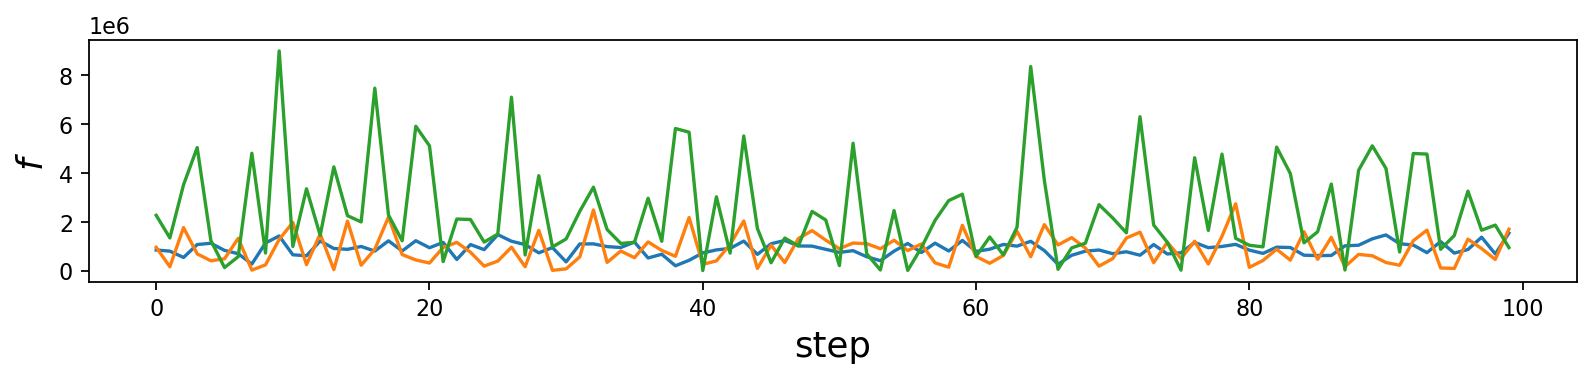

In [41]:
"""Some foreground amplitudes"""

fig, ax = plt.subplots(figsize=(12, 2),dpi=160)
#plt.plot(np.linspace(0,m,m),np.abs(np.mean(s_trace,axis=1)))
i, j, k = 3,2,0
plt.plot(np.arange(cut,m,1),np.abs(np.array(f_trace)[:,i,j,k]))
plt.plot(np.arange(cut,m,1),np.abs(np.array(f_trace)[:,2,5,4]))
plt.plot(np.arange(cut,m,1),np.abs(np.array(f_trace)[:,2,2,3]))
#plt.yscale('log')
plt.ylabel('$f$', fontsize = 16)
plt.xlabel('step', fontsize = 16)


In [42]:
F_trace = np.load('F_trace.npy')

Text(0.5, 0, 'step')

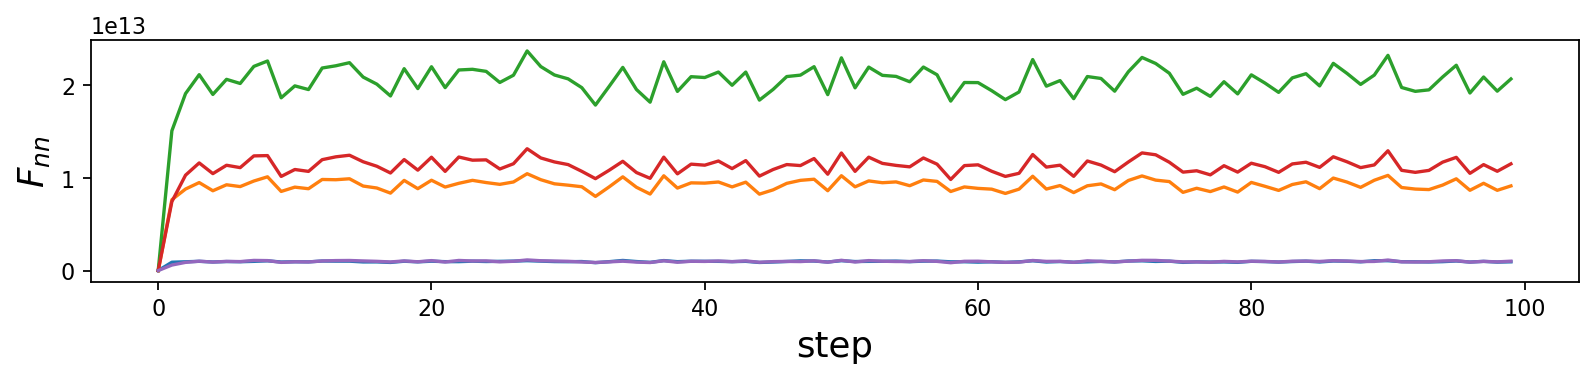

In [43]:
"""The values of the diagonal elements of the foreground covariance"""

fig, ax = plt.subplots(figsize=(12, 2),dpi=160)
plt.plot(np.arange(cut,m,1),F_trace[cut:m])
plt.ylabel('$F_{nn}$',fontsize=16)
plt.xlabel('step',fontsize=16)
#plt.savefig('plots/Fcov trace.jpg')

In [44]:
Pk_trace = np.array(np.load('Pk_trace.npy'))

Text(0.5, 0, 'step')

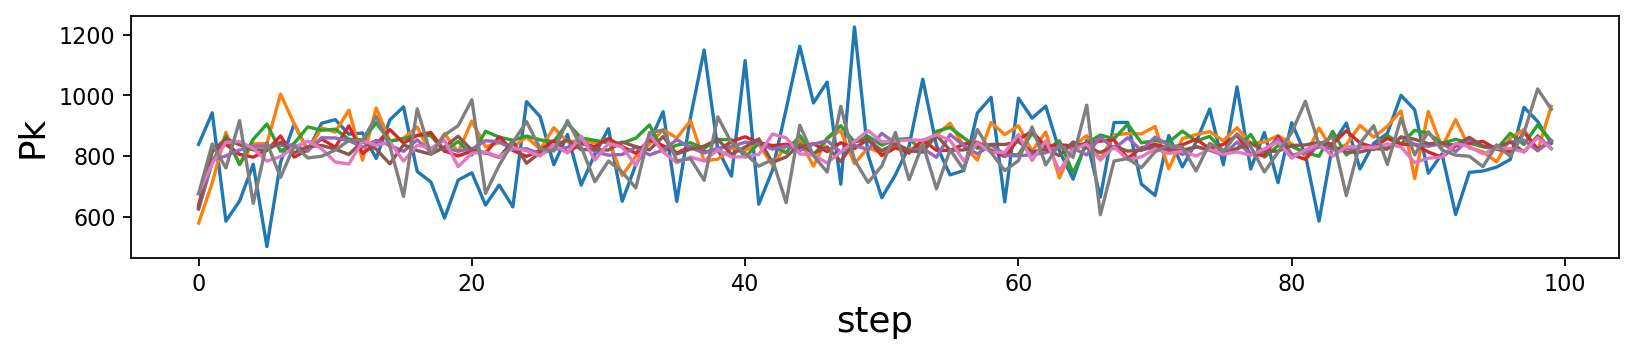

In [45]:
"""Power spectrum elements"""

fig, ax = plt.subplots(figsize=(12, 2),dpi=160)
plt.plot(np.arange(cut,m,1),np.array(Pk_trace)[cut:m])
plt.ylabel('Pk',fontsize=16)
plt.xlabel('step',fontsize=16)


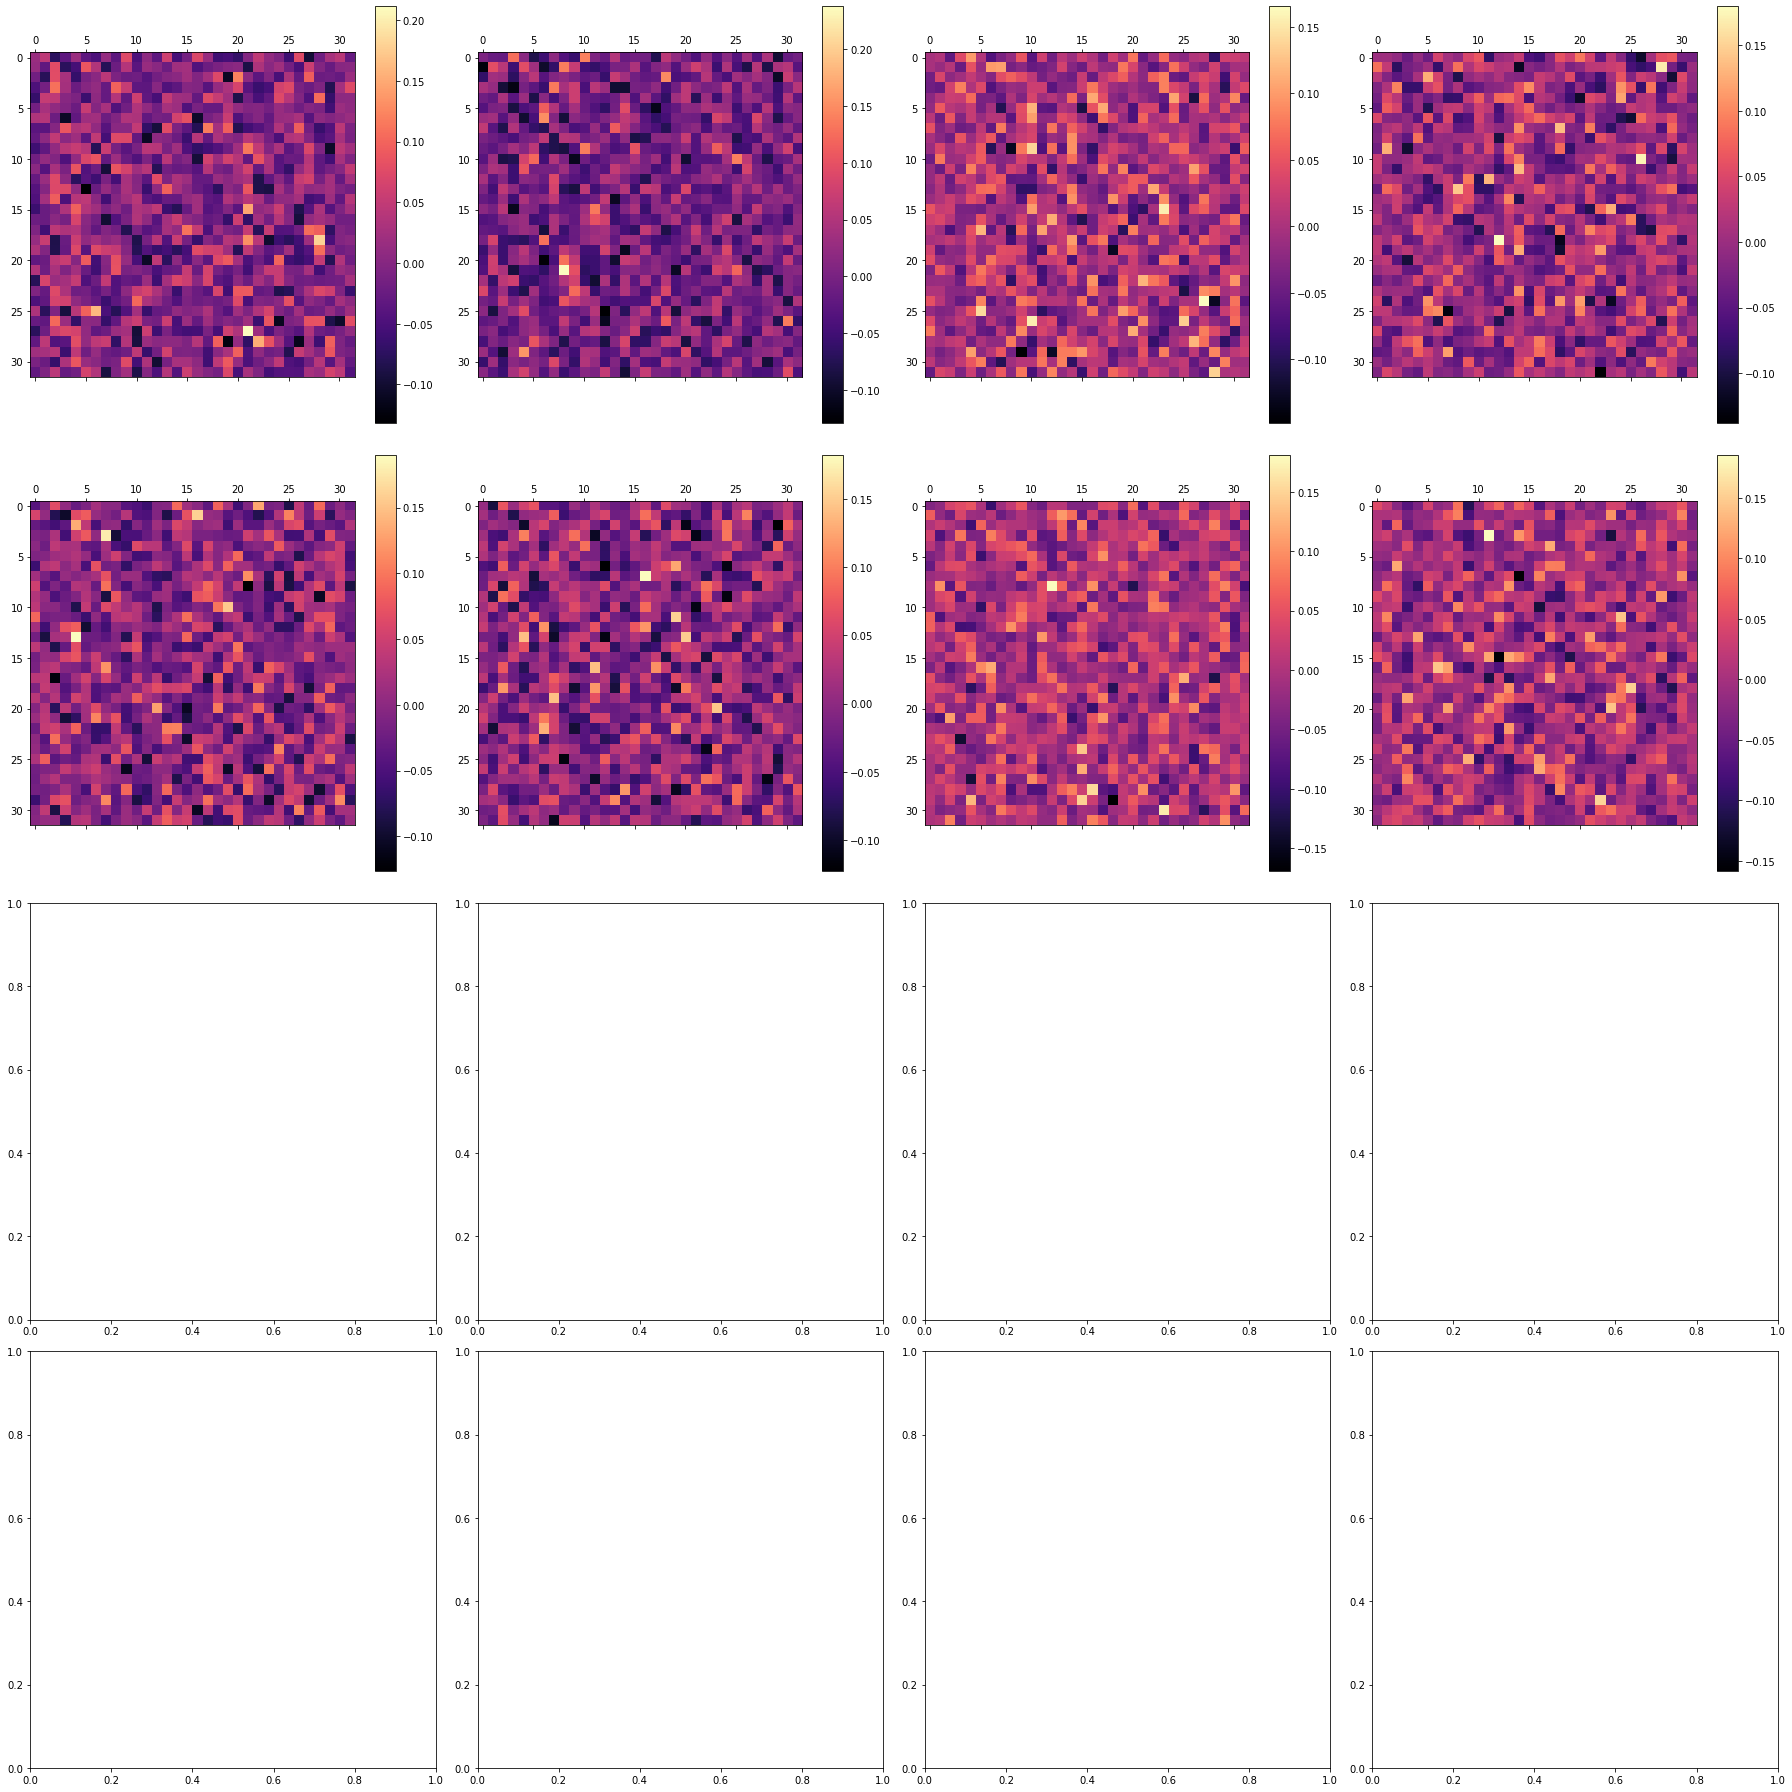

In [46]:
"""The average signal cube, averaged across all samples"""
cube_plot( Us(x_m,False),None,None)

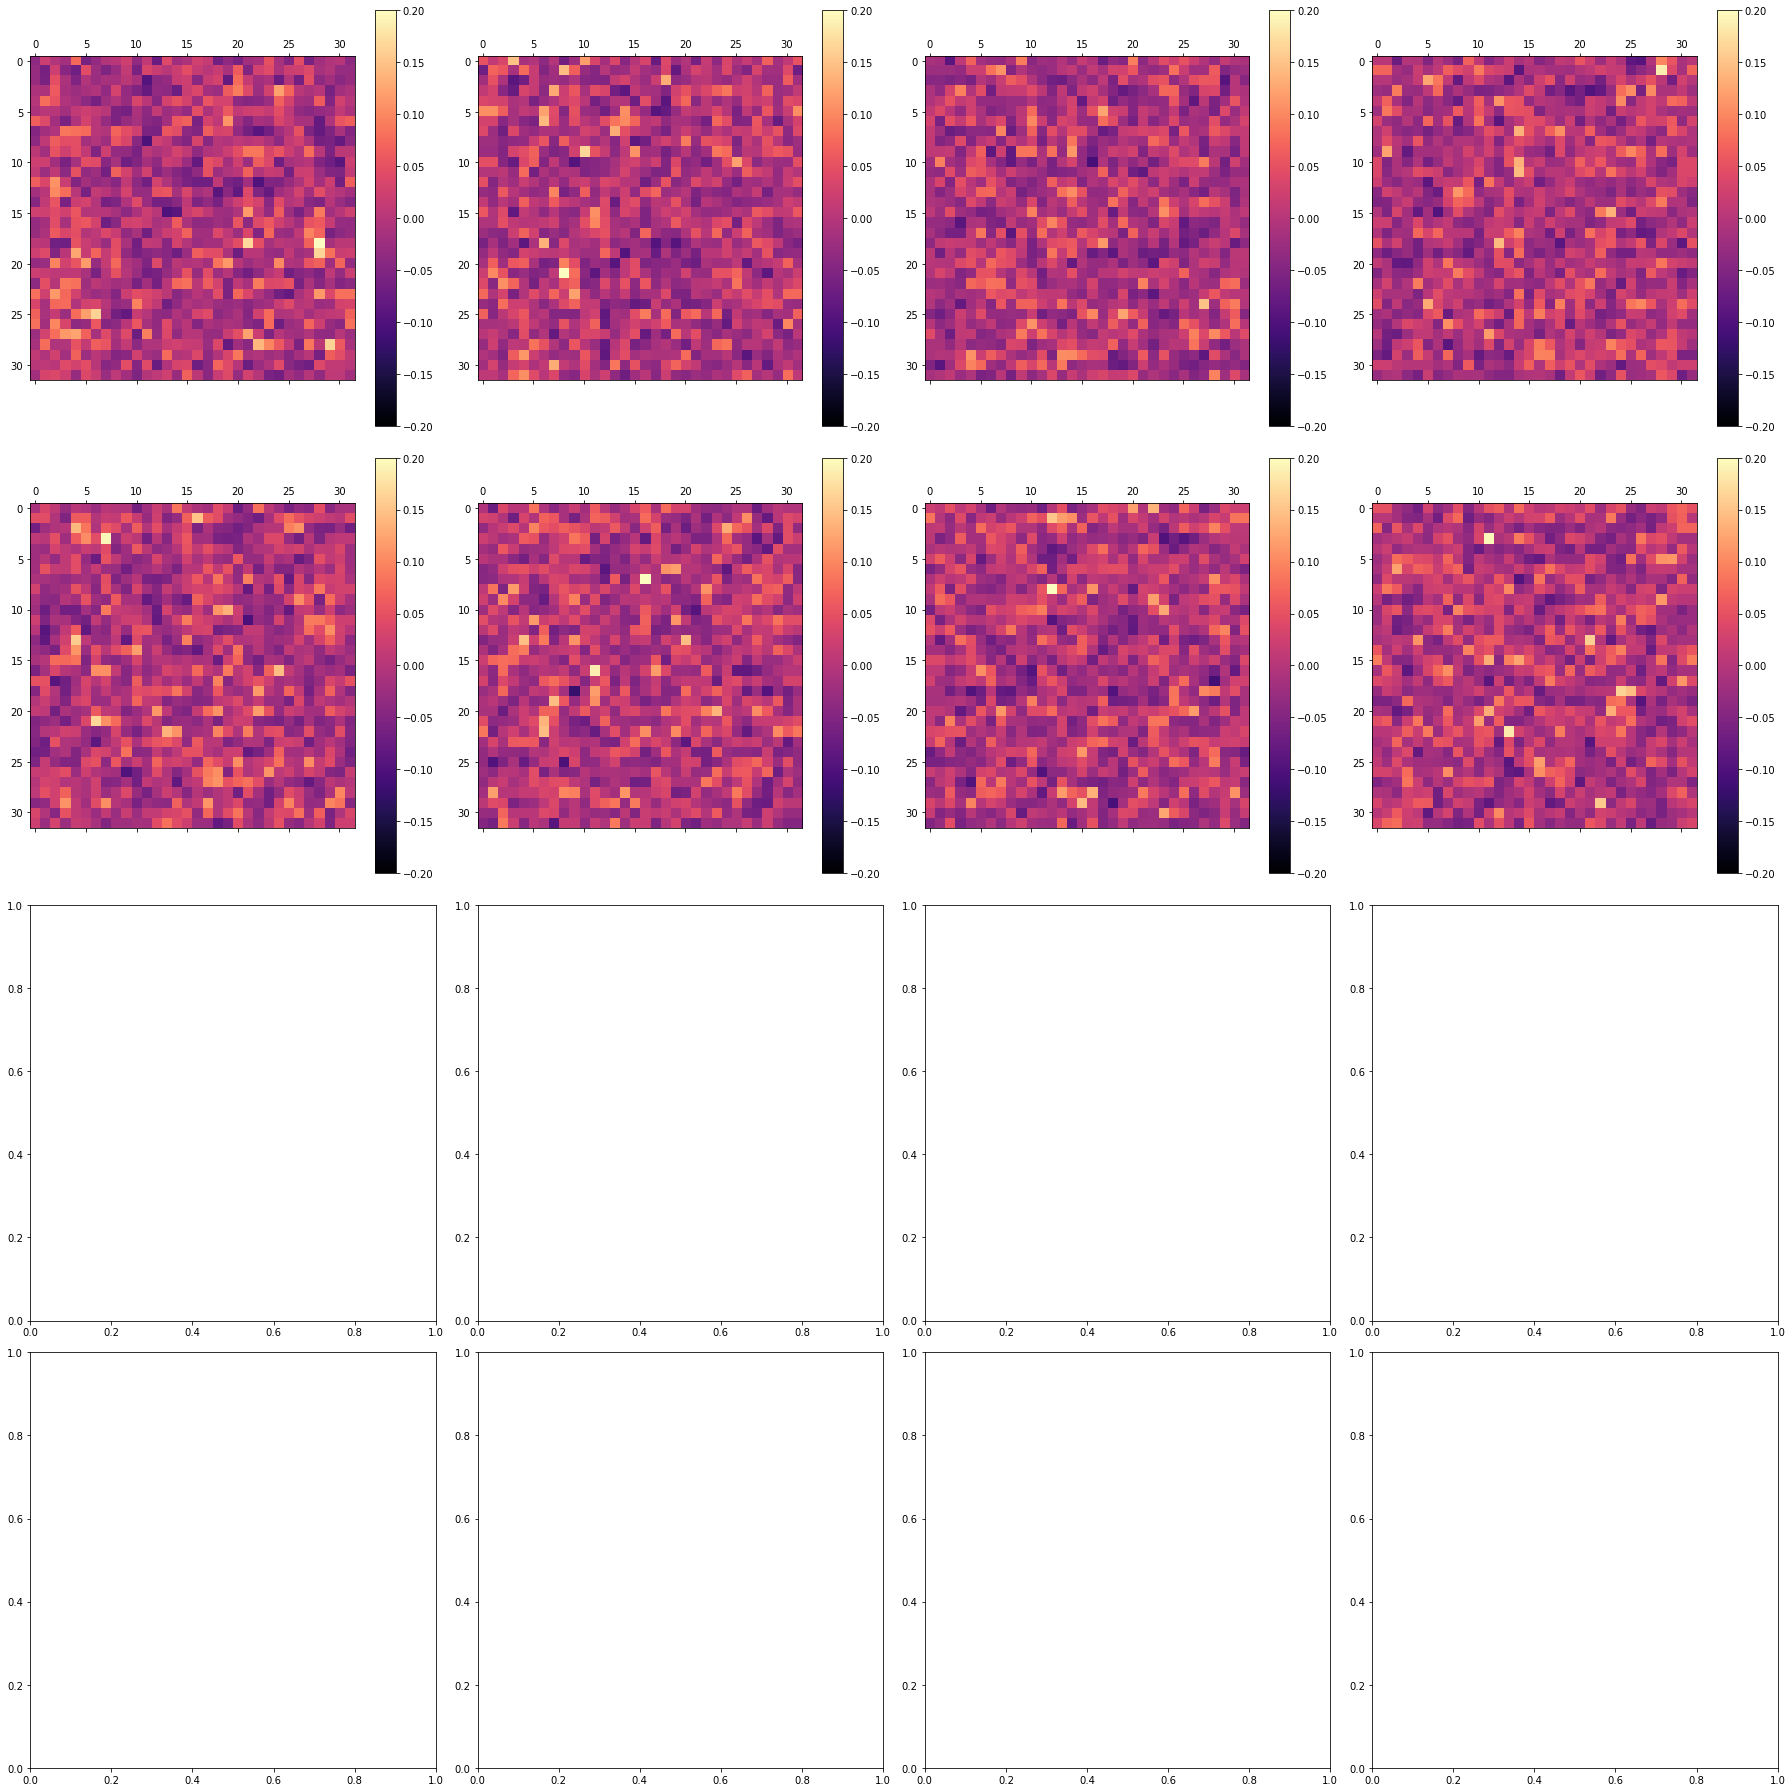

In [47]:
"""The mean-subtracted fiducial signal cube"""
cube_plot(signal_cube-np.mean(signal_cube),-0.2,0.2)

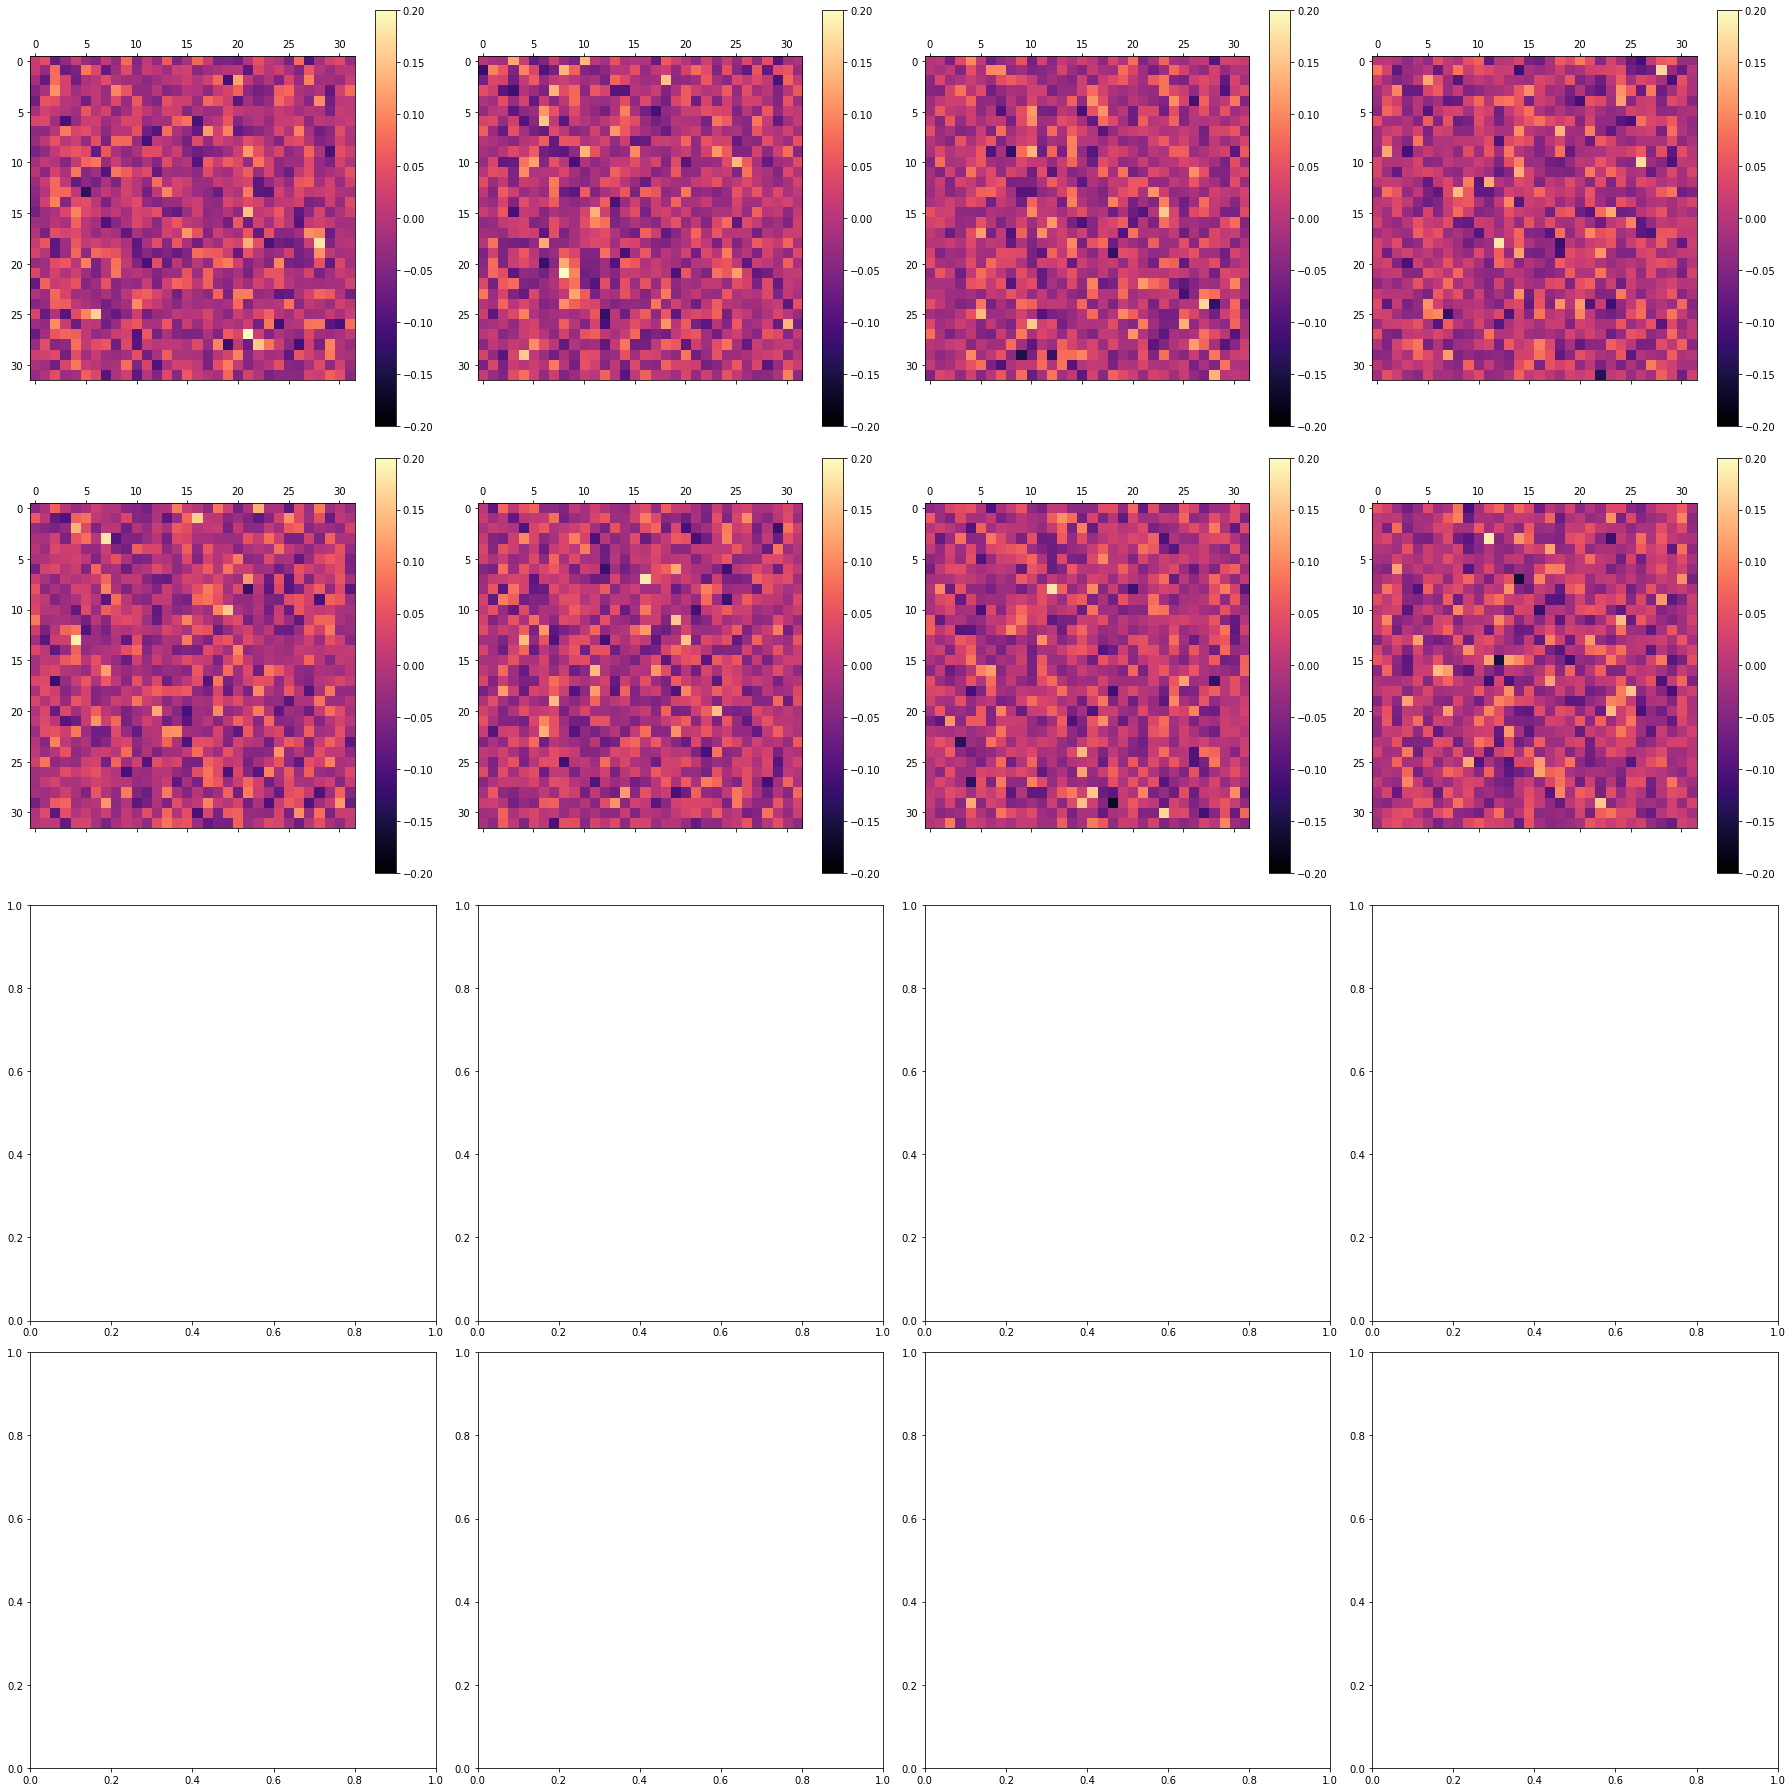

In [48]:
"""The mean-subtracted mean model result"""
cube_plot( Us(x_m,False) - np.mean(Us(x_m,False)),-0.2,0.2)

In [49]:
"""Plot the PS estimate, but for the mean signal result"""

s_res_mean = np.fft.fftn(np.fft.irfftn(x_m) - np.mean(np.fft.irfftn(x_m)))

binned_PS_out_mean, binned_PS_sum_out_mean, k_bins_out_mean = res_binner_check(s_res_mean.flatten(), n_k_bins, len(s_res))

C:\Users\Geoff\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\Geoff\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'log($\\sigma^2_k)$')

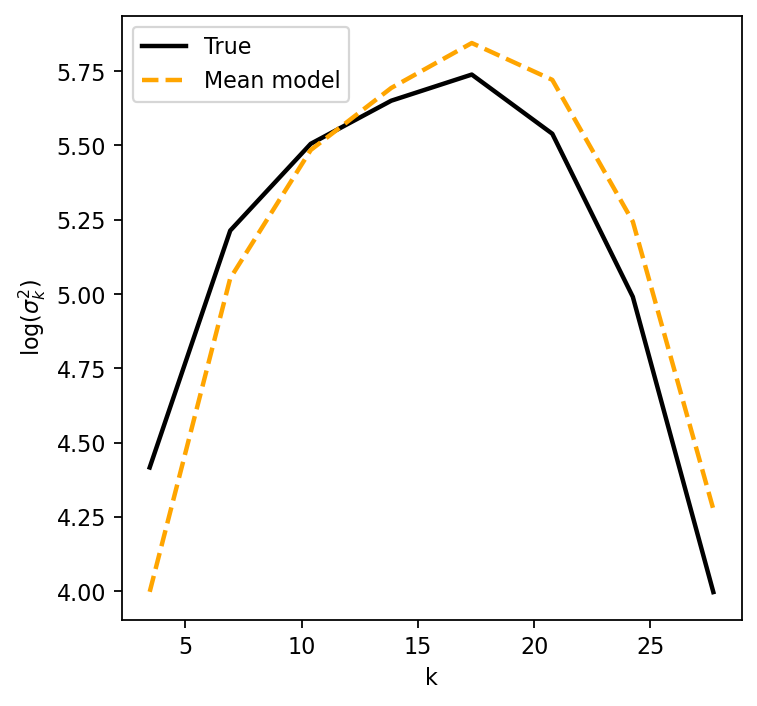

In [50]:
fig, ax = plt.subplots(figsize=(5, 5),dpi=160)

plt.plot(k_bins_out_true[1:], np.log10(binned_PS_sum_out_true),linestyle='-',linewidth=2, label='True', color='k')


plt.plot(k_bins_out_mean[1:], np.log10(binned_PS_sum_out_mean),linestyle='--',linewidth=2, label='Mean model',color='orange')
#plt.plot(kbins_out_nn[1:], np.log10(binned_s_sum_out_mean_nn),linestyle='-.',linewidth=2, label='Model + Noise',color='red')


plt.legend()
plt.xlabel('k')
plt.ylabel('log($\sigma^2_k)$')
#plt.savefig('plots/sig2_comp.jpg',bbox_inches='tight')

In [97]:
import corner

In [98]:
np.shape(Pk_trace)

(1000, 8)

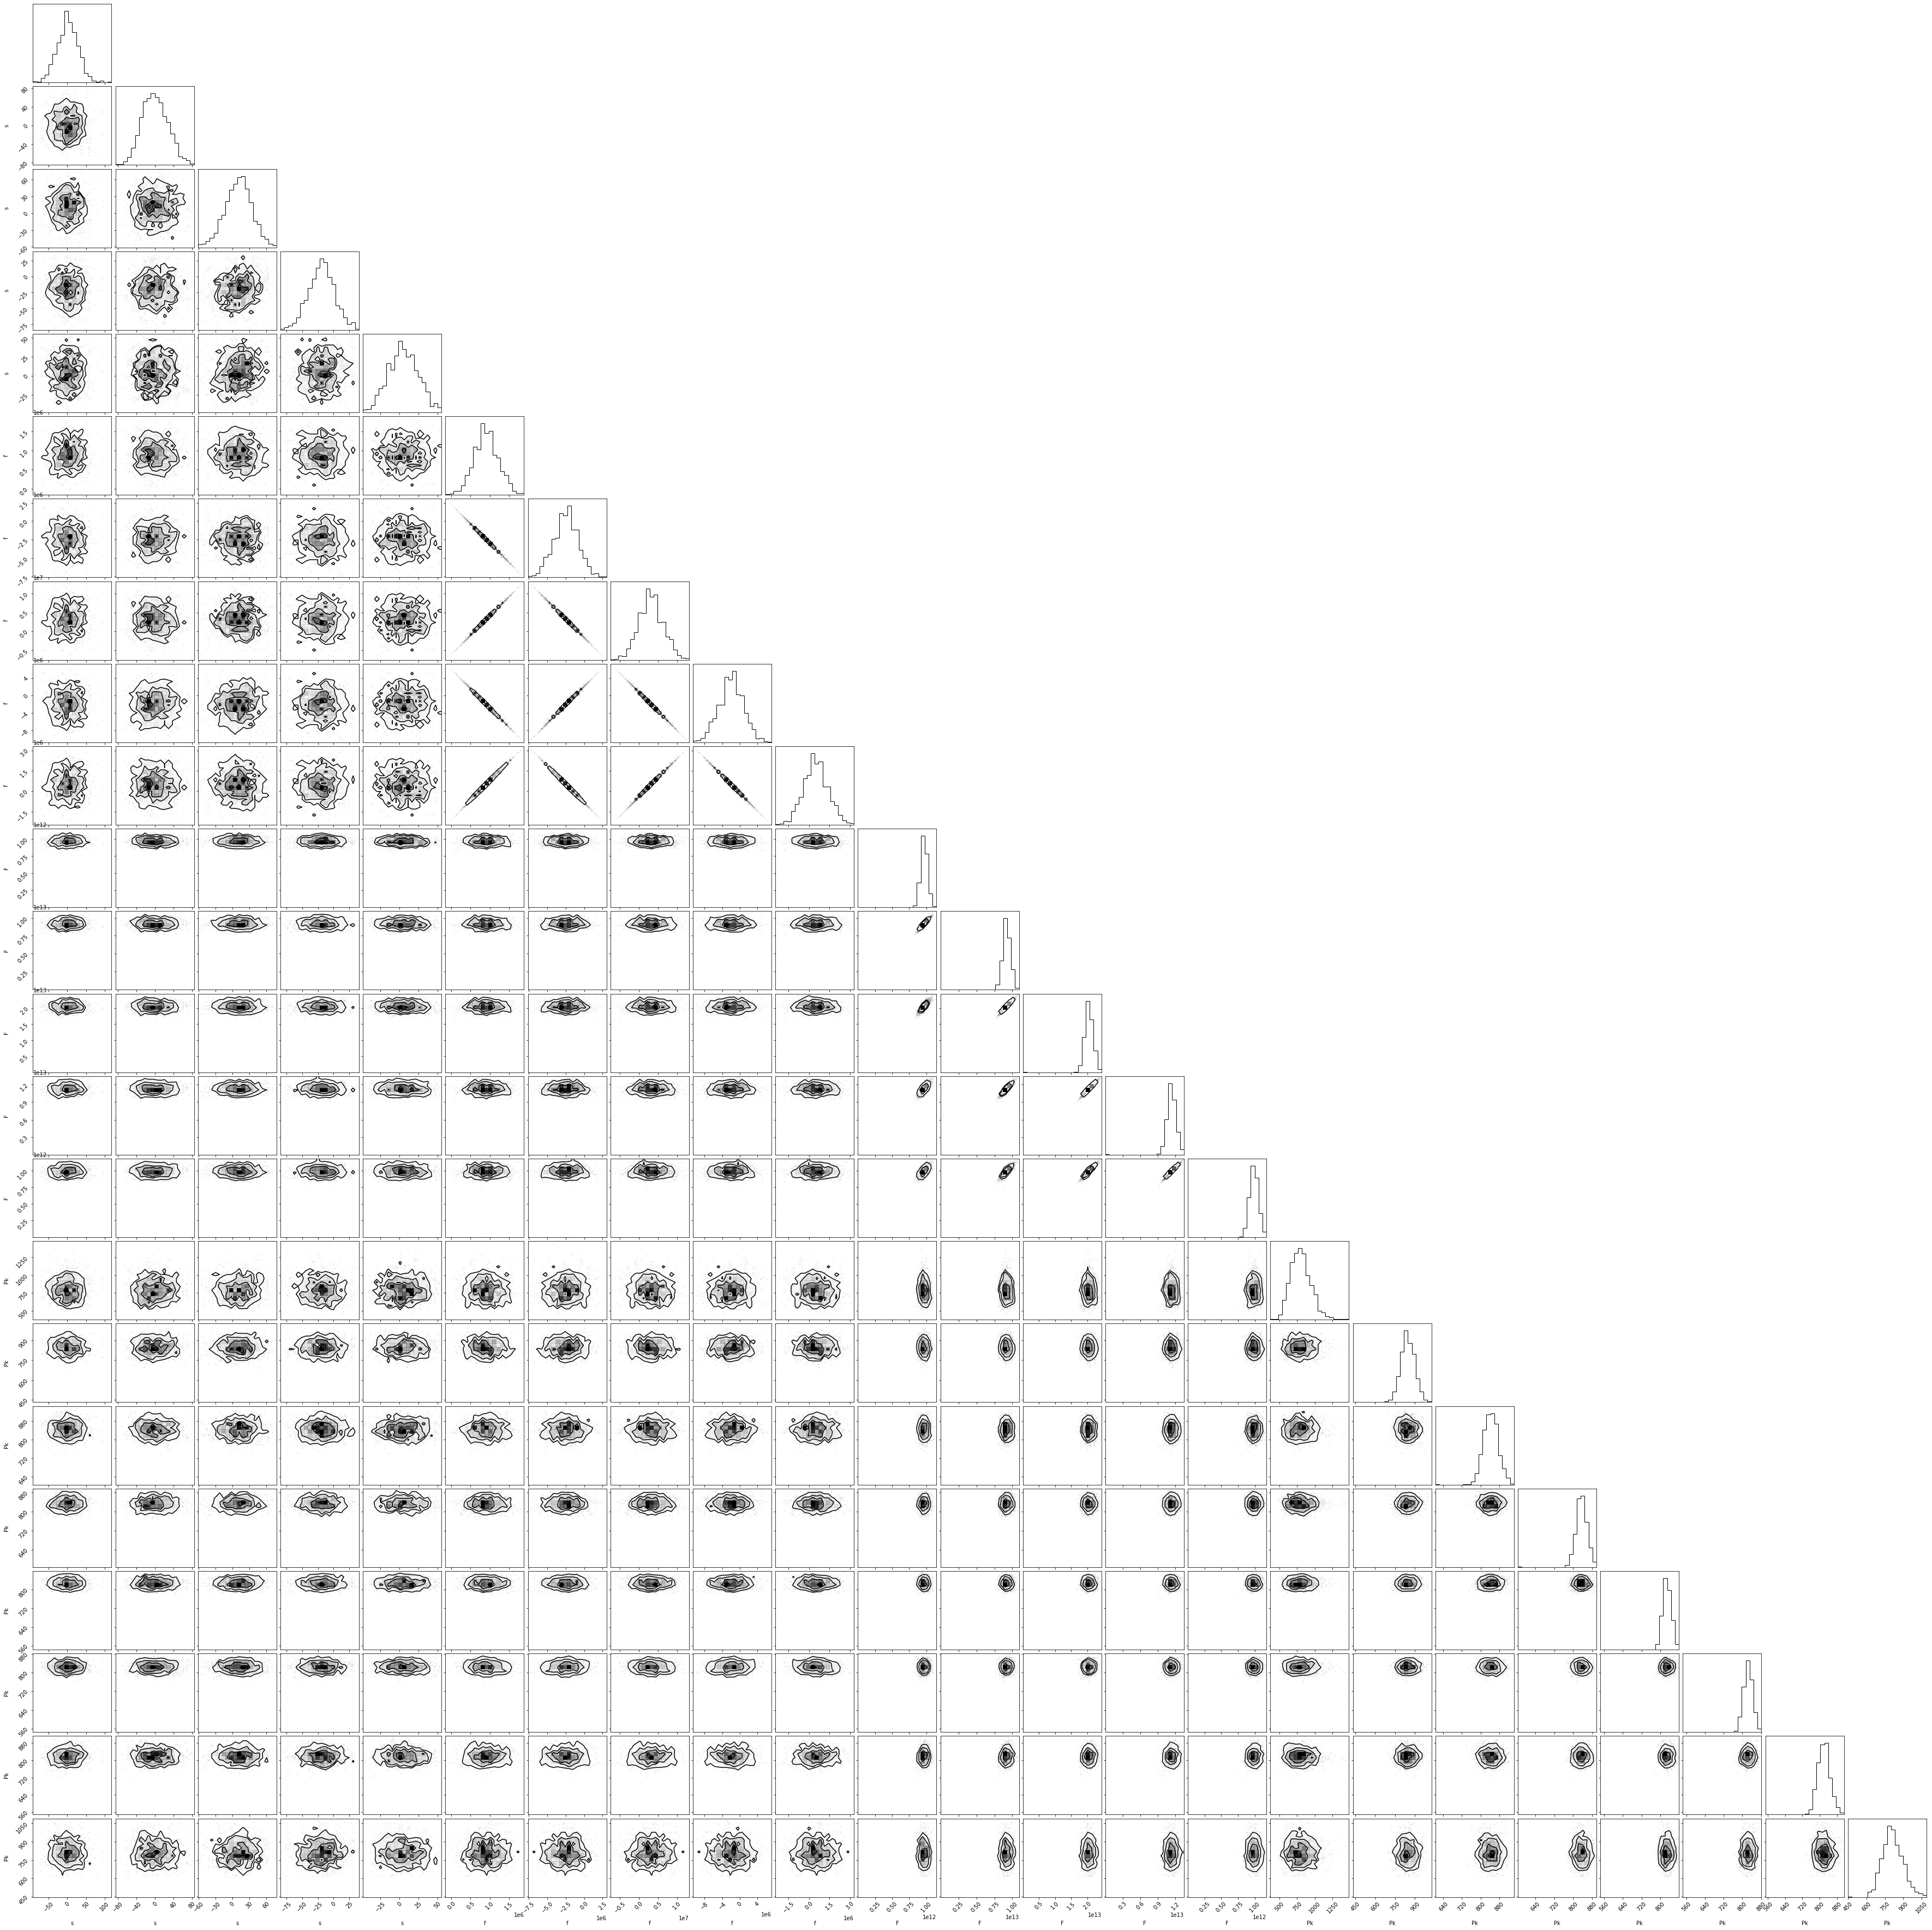

In [99]:
#ndim, nsamples = 2, 10000
a_i, b_i = np.random.randint(0,shape[0]), np.random.randint(0,shape[0])

#S_samps = np.array(S_trace)
s_samps = np.array(xses)[:,0,0,0:5].real
#s_samps = np.array(ffts_trace)[:,11,23,12:17]

F_samps = np.array(F_trace)
f_samps = np.array(f_trace)[:,0,0,0:5].real

#samples = np.random.randn(ndim * nsamples).reshape([nsamples, ndim])
samples = np.array([s_samps[:,0],s_samps[:,1],s_samps[:,2],s_samps[:,3],s_samps[:,4],f_samps[:,0],f_samps[:,1],f_samps[:,2],f_samps[:,3],f_samps[:,4],
                   F_samps[:,0],F_samps[:,1],F_samps[:,2],F_samps[:,3],F_samps[:,4],
                   Pk_trace[:,0],Pk_trace[:,1],Pk_trace[:,2],Pk_trace[:,3],Pk_trace[:,4],Pk_trace[:,5],Pk_trace[:,6],Pk_trace[:,7]]).T
figure = corner.corner(samples, labels=['s','s','s','s','s','f','f','f','f','f','F','F','F','F','F','Pk','Pk','Pk','Pk','Pk','Pk','Pk','Pk'])
#plt.savefig('plots/corner.jpg')